## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [90]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# ========== NEW IMPORTS ========
# Respect to notebook 02-Predicting-Survival-Titanic-Solution

# pipeline
from sklearn.pipeline import Pipeline

# for the preprocessors
from sklearn.base import BaseEstimator, TransformerMixin

# for imputation
from feature_engine.imputation import (
    CategoricalImputer,
    AddMissingIndicator,
    MeanMedianImputer
)
from sklearn.impute import SimpleImputer

# for encoding categorical variables
from feature_engine.encoding import (
    RareLabelEncoder,
    OneHotEncoder
)

## Prepare the data set

In [91]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [92]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [93]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [94]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [95]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [96]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [97]:
# # save the data set

# data.to_csv('titanic.csv', index=False)

# Begin Assignment

## Configuration

In [98]:
# list of variables to be used in the pipeline's transformers
target_name = "survived"

NUMERICAL_VARIABLES = ["age", "fare"]
CATEGORICAL_VARIABLES = [var for var in data.columns if data[var].dtypes == "O" and var != target_name]
CABIN = ["cabin"]

print(NUMERICAL_VARIABLES, CATEGORICAL_VARIABLES, CABIN)

['age', 'fare'] ['sex', 'cabin', 'embarked', 'title'] ['cabin']


## Separate data into train and test

In [99]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Preprocessors

### Class to extract the letter from the variable Cabin

In [100]:
class ExtractLetterTransformer(BaseEstimator, TransformerMixin):
    # Extract fist letter of variable

    def __init__(self, variables):
        
        if not isinstance(variables, list):
            raise ValueError('variables should be a list')
        
        self.variables = variables

    def fit(self, X, y=None):
        # we need this step to fit the sklearn pipeline
        print(X[self.variables].dtypes)
        return self

    def transform(self, X):

        # so that we do not over-write the original dataframe
        X = X.copy()

        for feature in self.variables:
            X[feature] = X[feature].str[0]

        return X

## Pipeline

- Impute categorical variables with string missing
- Add a binary missing indicator to numerical variables with missing data
- Fill NA in original numerical variable with the median
- Extract first letter from cabin
- Group rare Categories
- Perform One hot encoding
- Scale features with standard scaler
- Fit a Logistic regression

In [101]:
# set up the pipeline
from sklearn.compose import ColumnTransformer

categorical_imputer = SimpleImputer(strategy="constant", fill_value="missing")
numerical_imputer = SimpleImputer(strategy="median", add_indicator=True)

diff_type_col_imputer = ColumnTransformer(
    transformers=[
        ("cat_impute_missing", categorical_imputer, CATEGORICAL_VARIABLES),
        ("num_impute_median", numerical_imputer, NUMERICAL_VARIABLES)
    ]
)


titanic_pipe = Pipeline([

    # ===== IMPUTATION =====
    # impute categorical variables with string missing
    ('categorical_imputation', CategoricalImputer(
        imputation_method='missing', variables=CATEGORICAL_VARIABLES)),

    # add missing indicator to numerical variables
    ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARIABLES)),

    # impute numerical variables with the median
    ('median_imputation', MeanMedianImputer(
        imputation_method='median', variables=NUMERICAL_VARIABLES)),

    # # Extract first letter from cabin
    ('extract_letter', ExtractLetterTransformer(variables=CABIN)),

    # # == CATEGORICAL ENCODING ======
    # # remove categories present in less than 5% of the observations (0.05)
    # # group them in one category called 'Rare'
    ('rare_label_encoder', RareLabelEncoder(tol=0.05,
                                            n_categories=1,
                                            variables=CATEGORICAL_VARIABLES)),


    # # encode categorical variables using one hot encoding into k-1 variables
    ('categorical_encoder', OneHotEncoder(drop_last=True, variables=CATEGORICAL_VARIABLES)),

    # # scale using standardization
    ('scaler', StandardScaler()),

    # # logistic regression (use C=0.0005 and random_state=0)
    ('Logit', LogisticRegression(C=0.005, random_state=0)),
])

In [102]:
# train the pipeline
titanic_pipe.fit(X_train, y_train)


cabin    object
dtype: object


Pipeline(steps=[('categorical_imputation',
                 CategoricalImputer(variables=['sex', 'cabin', 'embarked',
                                               'title'])),
                ('missing_indicator',
                 AddMissingIndicator(variables=['age', 'fare'])),
                ('median_imputation',
                 MeanMedianImputer(variables=['age', 'fare'])),
                ('extract_letter',
                 ExtractLetterTransformer(variables=['cabin'])),
                ('rare_label_encoder',
                 RareLabelEncoder(n_categories=1,
                                  variables=['sex', 'cabin', 'embarked',
                                             'title'])),
                ('categorical_encoder',
                 OneHotEncoder(drop_last=True,
                               variables=['sex', 'cabin', 'embarked',
                                          'title'])),
                ('scaler', StandardScaler()),
                ('Logit', LogisticRegression(C=0.005, random_state=0))])

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

       auc-roc score  accuracy score
train       0.146932        0.808978
test        0.154846        0.786260


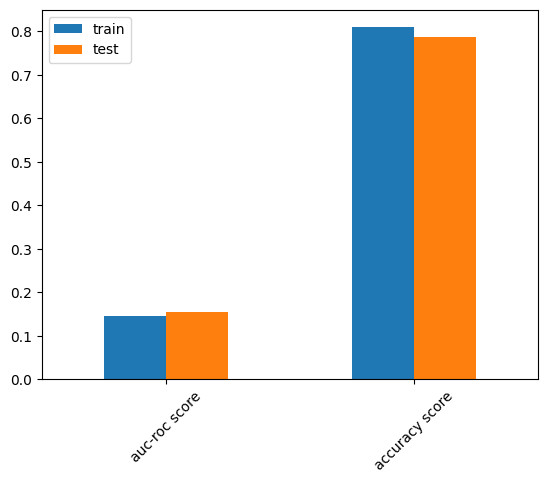

In [115]:
def create_aucroc_and_accuracy_df(train, test):
    metrics = ["auc-roc score", "accuracy score"]
    rows = ["train", "test"]

    dic = {}
    for i, metric in enumerate(metrics):
        dic[metric] = [train[i], test[i]]

    return pd.DataFrame(dic, index=rows)

# make predictions and compare performance
train_pred = titanic_pipe.predict(X_train)
train_prob = titanic_pipe.predict_proba(X_train)[:,0]

test_pred = titanic_pipe.predict(X_test)
test_prob = titanic_pipe.predict_proba(X_test)[:,0]

train_metrics = [
    roc_auc_score(y_train, train_prob),
    accuracy_score(y_train, train_pred)
]

test_metrics = [
    roc_auc_score(y_test, test_prob),
    accuracy_score(y_test, test_pred)
]

results = create_aucroc_and_accuracy_df(train_metrics, test_metrics)
print(results)
results.T.plot.bar(rot=45)
plt.show()

That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**